<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fmachine_learning/SI_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources:
* https://arxiv.org/pdf/1909.00125.pdf

# Imports

In [1]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
#--------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#--------------------------------------------------
from skimage.filters import gabor_kernel
from skimage import io, color
from skimage.feature import hog,local_binary_pattern
from scipy import ndimage as ndi
from skimage.feature import graycomatrix, graycoprops

In [2]:
!pip install opencv-python-headless
!pip install tqdm
#tqdm is a Python package that provides a progress bar for iterative tasks
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helpers

In [4]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [5]:
def extract_file(zip_path,specified_directory):
  # create a ZipFile object
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  # extract all contents to a specified directory
    zip_ref.extractall(specified_directory)


In [6]:
def read_images_gray( flooded_path,non_flooded_path,image_size):
    #create empty numpy arrays to store the images
    flooded = np.empty((0, image_size, image_size))
    non_flooded = np.empty((0, image_size, image_size))

    # loop through the images in the "flooded" folder
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size)) # resize the image to (224, 224)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        flooded = np.concatenate((flooded, img), axis=0)

    # loop through the images in the "non-flooded" folder
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size)) # resize the image to (224, 224)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded


In [7]:
def read_images_rgb( flooded_path,non_flooded_path,image_size):
    flooded = np.empty((0, image_size, image_size, 3))
    non_flooded = np.empty((0, image_size, image_size, 3))

    # loop through the images in the "flooded" folder
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (image_size, image_size)) # resize the image to (image_size, image_size)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        flooded = np.concatenate((flooded, img), axis=0)

    # loop through the images in the "non-flooded" folder
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (image_size, image_size)) # resize the image to (image_size, image_size)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [8]:
def show_images(images,images_labels,is_gray=True):
  if is_gray:
    Cmap='gray'
  else:
    Cmap=None
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic,cmap=Cmap)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

# Images reading 

In [9]:
extract_file("drive/MyDrive/Copy of dataset.zip","/content")

In [10]:
# flooded_gray,non_flooded_gray=read_images_gray("dataset/flooded","dataset/non-flooded",224)
flooded,non_flooded=read_images_rgb("dataset/flooded","dataset/non-flooded",224)

# print("gray flooded images shapes",flooded_gray.shape)
# print("gray non_flooded images shapes",non_flooded_gray.shape)
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (461, 224, 224, 3)
non_flooded images shapes (461, 224, 224, 3)


In [11]:
def split_data(flooded,non_flooded,shuffle=False,stratify=False):
  '''
  split data into train and test 
  '''
  stratify_1=None
  stratify_2=None
  if stratify:
    stratify_1=y
    stratify_2=y_test

  # concatenate the flooded and non-flooded images into a single numpy array
  X = np.concatenate((flooded, non_flooded), axis=0)
  # create the corresponding labels
  y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)
  # 80% training , 20% testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=shuffle,stratify=stratify_1)
  return X_train, X_test, y_train, y_test

In [12]:
def split_data_val(flooded,non_flooded,shuffle=False,stratify=False):
  '''
  split data into train, validation and test 
  '''
  stratify_1=None
  stratify_2=None
  if stratify:
    stratify_1=y
    stratify_2=y_test

  # concatenate the flooded and non-flooded images into a single numpy array
  X = np.concatenate((flooded, non_flooded), axis=0)
  # create the corresponding labels
  y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)
  # 80% training, 10% validation, 10% testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=shuffle,stratify=stratify_1)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,shuffle=shuffle,stratify=stratify_2)
  return X_train, X_test,X_val, y_train, y_test,y_val

In [13]:
  X_train, X_test, y_train, y_test=split_data(flooded,non_flooded,shuffle=True)
  print(X_train.shape, y_train.shape)  # should output the shapes of the training data
  print(X_test.shape, y_test.shape)  # should output the shapes of the training data

(737, 224, 224, 3) (737,)
(185, 224, 224, 3) (185,)


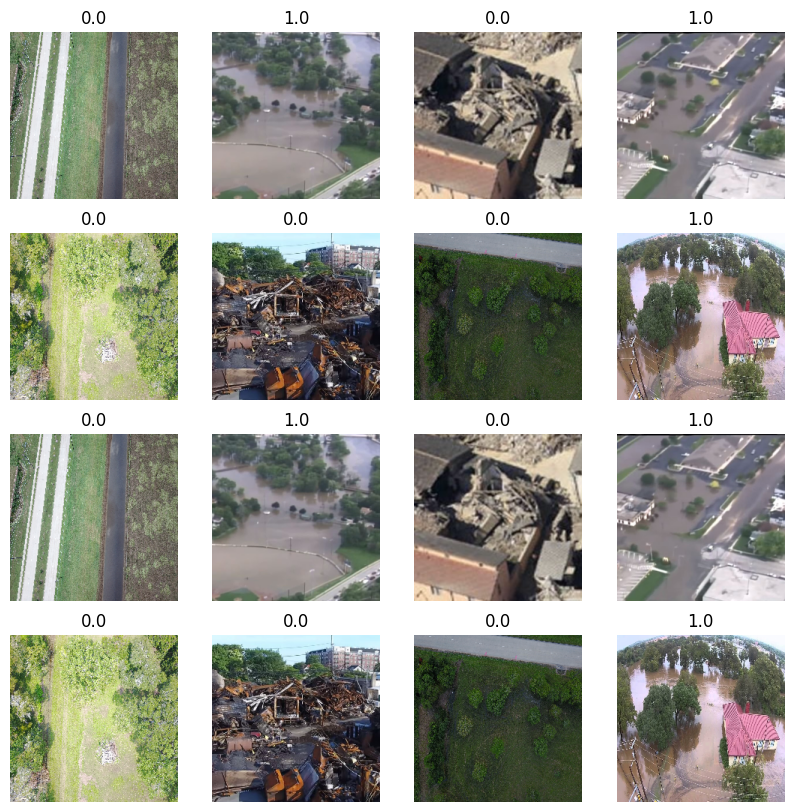

In [14]:
show_images(X_train,y_train,is_gray=False)

# Machine-learning approach

## Feature Extraction

In [15]:
from skimage.feature import greycomatrix, greycoprops

def haralick(data_color):
    data_haralick = []
    for i in range(len(data_color)):
        image = data_color[i]
        # Compute the Haralick features for each color channel separately
        haralick_r = compute_haralick(image[:,:,0])
        haralick_g = compute_haralick(image[:,:,1])
        haralick_b = compute_haralick(image[:,:,2])
        # Concatenate the features from all channels
        haralick = np.concatenate([haralick_r, haralick_g, haralick_b])
        data_haralick.append(haralick)
    data_haralick = np.array(data_haralick)
    return data_haralick

def compute_haralick(image_gray):
    # Convert the image to an unsigned integer format
    image_uint = (image_gray * 255).astype(np.uint8)
    # Compute the gray-level co-occurrence matrix
    glcm = graycomatrix(image_uint, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    # Compute the Haralick features
    haralick = np.array([graycoprops(glcm, prop).ravel()[0] for prop in ['contrast', 'homogeneity', 'energy', 'correlation']])
    return haralick

In [16]:
def lbp(data_color):
    radius = 3
    n_points = 8 * radius
    data_lbp = []
    for i in range(len(data_color)):
        image = data_color[i]
        # Compute the LBP features for each color channel separately
        lbp_r = compute_lbp(image[:,:,0], n_points, radius)
        lbp_g = compute_lbp(image[:,:,1], n_points, radius)
        lbp_b = compute_lbp(image[:,:,2], n_points, radius)
        # Concatenate the features from all channels
        lbp = np.concatenate([lbp_r, lbp_g, lbp_b])
        data_lbp.append(lbp)
    data_lbp = np.array(data_lbp)
    return data_lbp

def compute_lbp(image_gray, n_points, radius):
    # Compute the LBP features for a single color channel
    lbp = local_binary_pattern(image_gray, n_points, radius)
    return lbp.flatten()

In [17]:
def hog_func(data_color):
    ppc = 16
    hog_features = []
    for image in data_color:
        if len(image.shape) == 3:  # Color image
            hog_r = compute_hog(image[:,:,0], ppc)
            hog_g = compute_hog(image[:,:,1], ppc)
            hog_b = compute_hog(image[:,:,2], ppc)
            hog = np.concatenate([hog_r, hog_g, hog_b])
        else:  # Grayscale image
            hog = compute_hog(image, ppc)
        hog_features.append(hog)
    hog_features = np.array(hog_features)
    return hog_features

def compute_hog(image_gray, ppc):
    fd = hog(image_gray, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2')
    return fd

In [18]:
# def gabor_filter(data_gray):
#     kernels = []
#     for theta in range(2):
#         theta = theta / 4. * np.pi
#         for sigma in (1, 3):
#             for frequency in (0.05, 0.25):
#                 kernel = np.real(gabor_kernel(frequency, theta=theta,sigma_x=sigma, sigma_y=sigma))
#                 kernels.append(kernel)
#     data_gabor = []
#     for i in range(len(data_gray)):
#         filtered = np.array([ndi.convolve(data_gray[i], kernel, mode='wrap') for kernel in kernels])
#         data_gabor.append(filtered.flatten())
#     data_gabor = np.array(data_gabor)
#     return data_gabor


In [19]:
train_features = np.concatenate((hog_func(X_train),lbp(X_train),haralick(X_train)),axis=1)
test_features = np.concatenate((hog_func(X_test),lbp(X_test),haralick(X_test)),axis=1)

In [20]:
print(train_features.shape)

(737, 197004)


### RGB

## Models

In [21]:
flatten_X_train=X_train.reshape((X_train.shape[0], -1))
flatten_X_test=X_test.reshape((X_test.shape[0], -1))

### Logistic regression

In [22]:
# Create the logistic regression model with C=0.1
log_reg = LogisticRegression(C=0.1,max_iter=1000)

# Fit the model to the training data
log_reg.fit(flatten_X_train, y_train)

# Get the predicted labels for the testing data
y_pred = log_reg.predict(flatten_X_test)

# Evaluate the model on the testing data
score = log_reg.score(flatten_X_test, y_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the classification report
cr = classification_report(y_test, y_pred)

# Print the confusion matrix and classification report
print("Accuracy:", score)
print(cm)
print(cr)

Accuracy: 0.7243243243243244
[[68 28]
 [23 66]]
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73        96
         1.0       0.70      0.74      0.72        89

    accuracy                           0.72       185
   macro avg       0.72      0.72      0.72       185
weighted avg       0.73      0.72      0.72       185



In [23]:
# Create the logistic regression model with C=0.1
log_reg = LogisticRegression(C=0.1)

# Fit the model to the training data
log_reg.fit(train_features, y_train)

# Get the predicted labels for the testing data
y_pred = log_reg.predict(test_features)

# Evaluate the model on the testing data
score = log_reg.score(test_features, y_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the classification report
cr = classification_report(y_test, y_pred)

# Print the confusion matrix and classification report
print("Accuracy:", score)
print(cm)
print(cr)

Accuracy: 0.6432432432432432
[[58 38]
 [28 61]]
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.64        96
         1.0       0.62      0.69      0.65        89

    accuracy                           0.64       185
   macro avg       0.65      0.64      0.64       185
weighted avg       0.65      0.64      0.64       185



### Random forest

In [24]:
# Create the random forest classifier with max_depth=10 and n_estimators=100
rfc = RandomForestClassifier(max_depth=10, n_estimators=100)

# Fit the model to the training data
rfc.fit(flatten_X_train, y_train)

# Evaluate the model on the testing data
score = rfc.score(flatten_X_test, y_test)

# Get the predicted labels for the testing data
y_pred = rfc.predict(flatten_X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the classification report
cr = classification_report(y_test, y_pred)

# Print the accuracy, confusion matrix, and classification report
print("Accuracy:", score)
print("Confusion matrix:")
print(cm)
print("Classification report:")
print(cr)

Accuracy: 0.772972972972973
Confusion matrix:
[[70 26]
 [16 73]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.81      0.73      0.77        96
         1.0       0.74      0.82      0.78        89

    accuracy                           0.77       185
   macro avg       0.78      0.77      0.77       185
weighted avg       0.78      0.77      0.77       185



In [25]:
# Create the random forest classifier with max_depth=10 and n_estimators=100
rfc = RandomForestClassifier(max_depth=10, n_estimators=100)

# Fit the model to the training data
rfc.fit(train_features, y_train)

# Evaluate the model on the testing data
score = rfc.score(test_features, y_test)

# Get the predicted labels for the testing data
y_pred = rfc.predict(test_features)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the classification report
cr = classification_report(y_test, y_pred)

# Print the accuracy, confusion matrix, and classification report
print("Accuracy:", score)
print("Confusion matrix:")
print(cm)
print("Classification report:")
print(cr)

Accuracy: 0.7567567567567568
Confusion matrix:
[[65 31]
 [14 75]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.82      0.68      0.74        96
         1.0       0.71      0.84      0.77        89

    accuracy                           0.76       185
   macro avg       0.77      0.76      0.76       185
weighted avg       0.77      0.76      0.76       185



### SVM

In [26]:
# Create the SVM classifier with C=10, gamma=0.0001, and kernel='rbf'
svm = SVC(C=10, gamma=0.0001, kernel='rbf')

# Fit the model to the training data
svm.fit(flatten_X_train, y_train)

# Evaluate the model on the testing data
score = svm.score(flatten_X_test, y_test)

# Get the predicted labels for the testing data
y_pred = svm.predict(flatten_X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the classification report
cr = classification_report(y_test, y_pred)

# Print the accuracy, confusion matrix, and classification report
print("Accuracy:", score)
print("Confusion matrix:")
print(cm)
print("Classification report:")
print(cr)

Accuracy: 0.7513513513513513
Confusion matrix:
[[72 24]
 [22 67]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76        96
         1.0       0.74      0.75      0.74        89

    accuracy                           0.75       185
   macro avg       0.75      0.75      0.75       185
weighted avg       0.75      0.75      0.75       185



In [27]:
# Create the SVM classifier with C=10, gamma=0.0001, and kernel='rbf'
svm = SVC(C=10, gamma=0.0001, kernel='rbf')

# Fit the model to the training data
svm.fit(train_features, y_train)

# Evaluate the model on the testing data
score = svm.score(test_features, y_test)

# Get the predicted labels for the testing data
y_pred = svm.predict(test_features)

In [28]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the classification report
cr = classification_report(y_test, y_pred,zero_division=1)

# Print the accuracy, confusion matrix, and classification report
print("Accuracy:", score)
print("Confusion matrix:")
print(cm)
print("Classification report:")
print(cr)

Accuracy: 0.4810810810810811
Confusion matrix:
[[ 0 96]
 [ 0 89]]
Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00        96
         1.0       0.48      1.00      0.65        89

    accuracy                           0.48       185
   macro avg       0.74      0.50      0.32       185
weighted avg       0.75      0.48      0.31       185



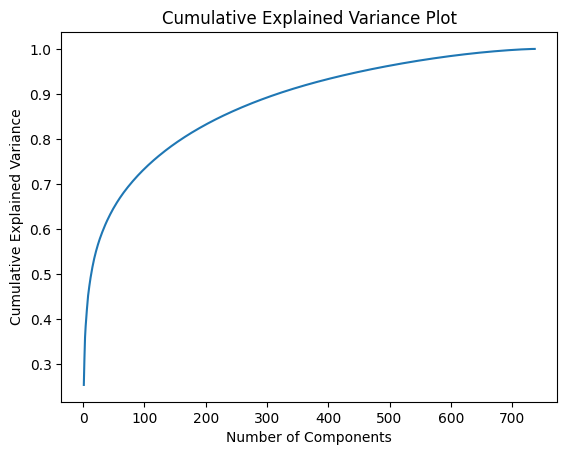

In [29]:
# Load the iris dataset
X = flatten_X_train

# Create a PCA object
pca = PCA()

# Fit the PCA model to the data
pca.fit(X)

# Calculate the cumulative explained variance
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.arange(1, len(cumulative_var) + 1), cumulative_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.show()

In [30]:
# Create a PCA object 
pca = PCA(n_components=600)

# Create an SVM classifier with C=1.0 and kernel='rbf'
svm = SVC(C=10, gamma=0.0001, kernel='rbf')

# Create a pipeline that combines PCA and SVM
pipeline = Pipeline([('pca', pca), ('svm', svm)])

# Fit the pipeline to the training data
pipeline.fit(flatten_X_train, y_train)

# Evaluate the pipeline on the testing data
score = pipeline.score(flatten_X_test, y_test)

# Get the predicted labels for the testing data
y_pred = pipeline.predict(flatten_X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the classification report
cr = classification_report(y_test, y_pred)

# Print the accuracy, confusion matrix, and classification report
print("Accuracy:", score)
print("Confusion matrix:")
print(cm)
print("Classification report:")
print(cr)

Accuracy: 0.7837837837837838
Confusion matrix:
[[68 28]
 [12 77]]
Classification report:
              precision    recall  f1-score   support

         0.0       0.85      0.71      0.77        96
         1.0       0.73      0.87      0.79        89

    accuracy                           0.78       185
   macro avg       0.79      0.79      0.78       185
weighted avg       0.79      0.78      0.78       185

